In [57]:
from IPython.display import display, HTML
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
from urllib.request import urlopen

import warnings
warnings.filterwarnings('ignore')

# Goal
Build a way of comparing the current county-level data teams (NYT, Larry, Johns Hopkins) as a way of guiding our own internal decision-making and perhaps as a way to expand what we show on state pages.  

Compare the NYT's county info and to Johns Hopkins and the COVIDAtlas folks. 
We're trying to rule out playing a role in county data, but we have not looked closely enough to know if they all fail in the same places or if it is more complicated than that.

More details:
[Jeff's Slack Thread](https://covid-tracking.slack.com/archives/CUW8MKCD7/p1585186860038300)

# Utils

In [2]:
state_abbrevs = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

state_full_names = dict([(value, key) for key, value in state_abbrevs.items()]) 

palette = {
    "pink":"#DB3069",
    "grey":"#313638",
    "gold":"#F5D547",
    "aqua":"#C1FFE8",
    "royal":"#1446A0",
    "fox":"#F06543"
}

def max_print(df) -> None:
    """Print the entire contents of a dataframe"""
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
         display(HTML(df.to_html()))

# Get Data

In [3]:
def get_csbs_df():
    response = urlopen("http://coronavirus-tracker-api.herokuapp.com/v2/locations?source=csbs")
    json_data = response.read().decode('utf-8', 'replace')
    d = json.loads(json_data)
    df = json_normalize(d['locations'])
    
    # remove "extras"
    df = df \
        .loc[df["country"] == "US"] \
        .rename(columns={
            "province":"state", 
            "latest.confirmed":"cases",
            "latest.deaths":"deaths",
            "latest.recovered":"recovered"}) \
        .drop(["id","country_population","country","country_code",
            "coordinates.latitude","coordinates.longitude"], axis=1)
    df["source"] = "csbs"
    return df

def get_cds_df():
    """
    Retrieved from:
    https://coronadatascraper.com/#data.csv
    Updated: March 25, 9pm PST
    """
    cds = pd.read_csv("./data/cds_data.csv")
    cds = cds \
        .loc[(cds["country"] == "USA") & (~cds["county"].isnull())] \
        .drop(["city","country","lat","long","url","maintainers",
            "aggregate","tz","featureId","sources","curators"], axis=1)
        
    cds["state"] = cds["state"].map(state_full_names)
    cds["county"] = cds["county"].apply(lambda x: x.replace("County", "").strip())
    cds["source"] = "cds"
    return cds

def get_nyt_df():
    """ 
    Retrieved from: https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html#g-cases-by-county
    Updated: March 26, 2020, 1:13 P.M. E.T.
    """
    nyt = pd.read_csv("./data/nyt_data.csv", sep="\t", header=None)
    nyt.columns = ["state", "county","cases", "deaths"]
    nyt["cases"] = nyt["cases"].apply(lambda x: x.replace(",", "")).astype(int)
    nyt["source"] = "nyt"
    return nyt

In [4]:
csbs = get_csbs_df()
cds = get_cds_df()
nyt = get_nyt_df()

In [ ]:
# saving to a file since API data will auto pull above while
# cds and nyt are a snapshot. You'll need to import the csv
# here if you are NOT regrabbing cds and nyt data at the time
# of the pull
csbs.to_csv("./data/csbs_data.csv", index=False)

In [5]:
long_df = pd.concat([csbs, cds, nyt], axis=0, sort=False)

# Analysis

In [6]:
max_print(csbs.head())

,county,last_updated,cases,deaths,recovered,state,source
0,New York,2020-03-26T19:54:00Z,21873,281,0,New York,csbs
1,Westchester,2020-03-26T19:54:00Z,5944,1,0,New York,csbs
2,Nassau,2020-03-26T19:54:00Z,3914,17,0,New York,csbs
3,Suffolk,2020-03-26T19:54:00Z,2735,22,0,New York,csbs
4,Rockland,2020-03-26T19:54:00Z,1197,5,0,New York,csbs


In [7]:
max_print(cds.head())

,county,state,cases,deaths,recovered,tested,active,population,rating,source
522,Gulf Coast Economic Region,Alaska,5,NaN,NaN,NaN,NaN,80866.0,0.372549,cds
523,Interior Economic Region,Alaska,11,NaN,NaN,NaN,NaN,109847.0,0.372549,cds
524,Mat-Su Economic Region,Alaska,2,NaN,NaN,NaN,NaN,107610.0,0.372549,cds
525,Northern Economic Region,Alaska,0,NaN,NaN,NaN,NaN,27432.0,0.372549,cds
526,Southeast Economic Region,Alaska,13,NaN,NaN,NaN,NaN,72373.0,0.372549,cds


In [8]:
max_print(nyt.head())

,state,county,cases,deaths,source
0,Alabama,Autauga,5,0,nyt
1,Alabama,Baldwin,4,0,nyt
2,Alabama,Blount,2,0,nyt
3,Alabama,Butler,1,0,nyt
4,Alabama,Calhoun,2,0,nyt


### Which dataset has the most county data?

In [9]:
csbs_states = csbs["state"].drop_duplicates().values
cds_states = cds["state"].drop_duplicates().values
nyt_states = nyt["state"].drop_duplicates().values

def get_missing_states(state_list):
    full_state_pool = set(csbs_states) 
    full_state_pool.update(cds_states)
    full_state_pool.update(nyt_states)
    
    return [s for s in full_state_pool if s not in state_list]

print(f"""
    The NYT includes all states. CSBS has all but the {get_missing_states(csbs_states)[0]}.
    CDS is missing a few states: {', '.join(get_missing_states(cds_states))}
    """)


    The NYT includes all states. CSBS has all but the Virgin Islands.
    CDS is missing a few states: Guam, North Dakota, Puerto Rico, Vermont, District of Columbia, Virgin Islands
    


In [10]:
print(f'CSBS\tCounty Total: {csbs[["state","county"]].drop_duplicates().shape[0]}')
print(f'CDS\tCounty Total: {cds[["state","county"]].drop_duplicates().shape[0]}')
print(f'NYT\tCounty Total: {nyt[["state","county"]].drop_duplicates().shape[0]}')

CSBS	County Total: 1636
CDS	County Total: 3043
NYT	County Total: 1572


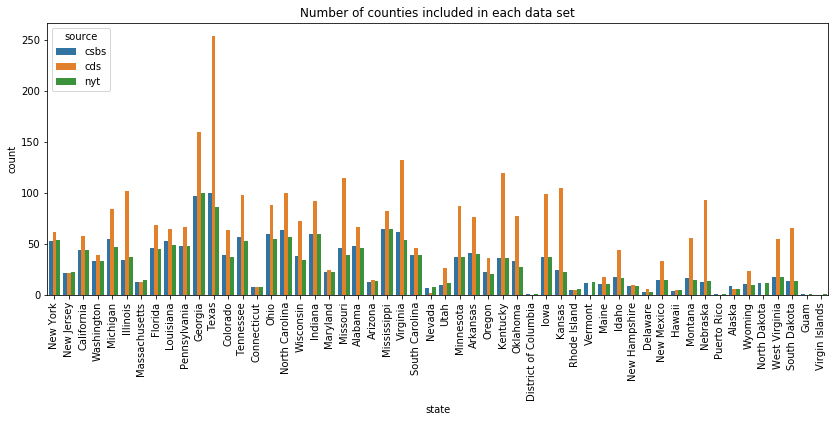

In [11]:
fig = plt.figure(figsize=(14,5))

ax = sns.countplot(
    x="state",
    hue="source",
    data=long_df
)

ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
ax.set(
    title="Number of counties included in each data set"
)
plt.show()

CDS has all counties listed, but many counties have 0 data or have reported 0 cases and were not included in the other datasets.

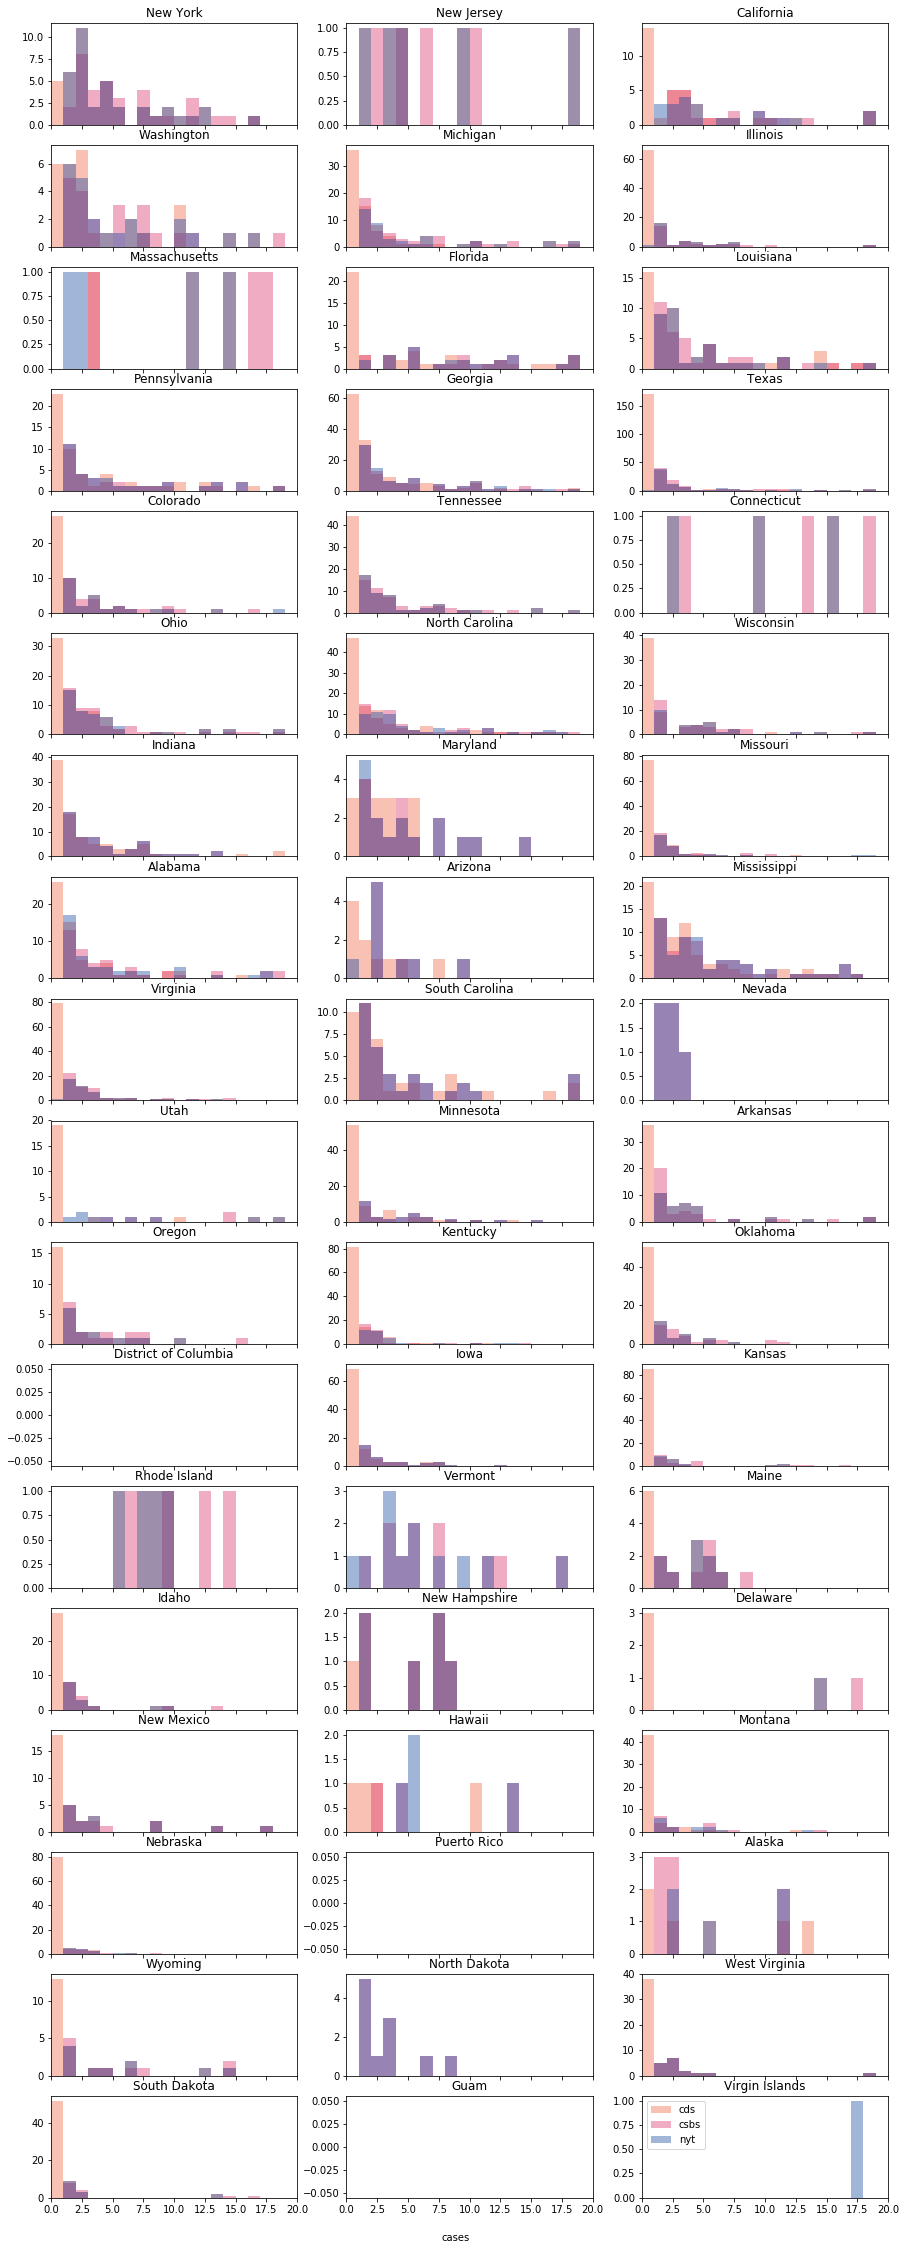

In [12]:
states = long_df["state"].drop_duplicates()

fig, axs = plt.subplots(18,3, figsize=(15, 40), sharex=True)

for s, ax in zip(states, axs.ravel()):
                
    xlim = (0,20)
    long_df_state = long_df.loc[(long_df["state"] == s) & (long_df["cases"] <= xlim[1])] 
    bins=range(0, xlim[1], 1)
    
    sns.distplot(
        long_df_state.loc[long_df_state["source"] == "cds"]["cases"],
        color=palette["fox"],
        ax=ax,
        kde=False,
        label="cds",
        bins=bins
    )
    
    sns.distplot(
        long_df_state.loc[long_df_state["source"] == "csbs"]["cases"],
        color=palette["pink"],
        kde=False,
        ax=ax,
        label="csbs",
        bins=bins
    )
    
    sns.distplot(
        long_df_state.loc[long_df_state["source"] == "nyt"]["cases"],
        color=palette["royal"],
        kde=False,
        ax=ax,
        label="nyt",
        bins=bins
    )
    
    ax.set(
        xlim=xlim,
        xlabel=None,
        title=s
    )

fig.text(0.5, 0.11, 'cases', ha='center')
plt.legend()
plt.show()

In [13]:
def plot_counties_with_data(states=None) -> None:
    
    fig = plt.figure(figsize=(16,5))

    to_plot = long_df.loc[long_df["cases"] > 0]
    
    if states:
        to_plot = to_plot.loc[to_plot["state"].isin(states)]
        
    ax = sns.countplot(
        x="state",
        hue="source",
        data=to_plot
    )

    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
    ax.set(
        title="Number of counties in each data set with recorded cases"
    )
    plt.show()

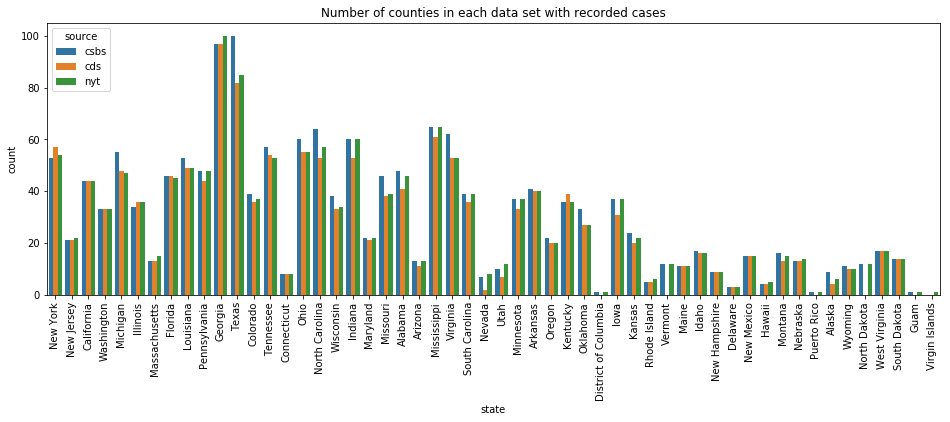

In [14]:
plot_counties_with_data()

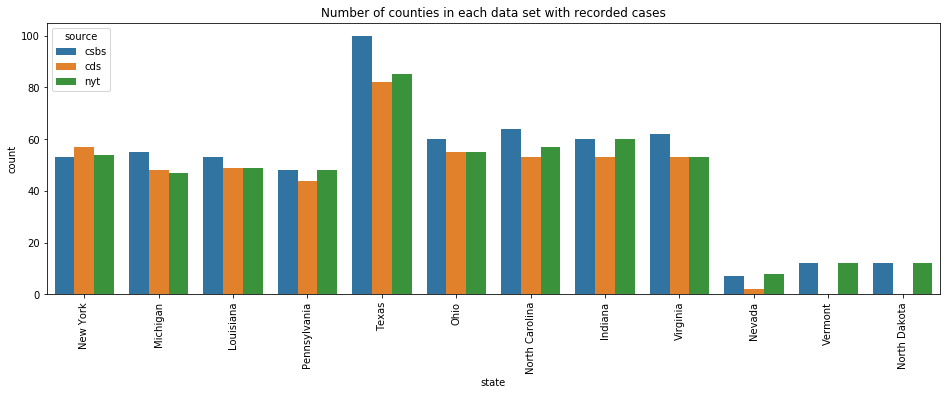

In [15]:
# highlighting the differences
plot_counties_with_data(["New York", "Michigan", "Louisiana", "Pennsylvania",
                        "Texas", "Ohio", "North Carolina", "Indiana", "Nevada", "Virginia",
                        "Vermont", "North Dakota"])

### How similar are the counties we have data for?

In [16]:
wide_df = cds.merge(csbs, how="outer", on=["state", "county"], suffixes=["_csbs","_cds"]) \
    .drop(["source_csbs","source_cds"], axis=1)
wide_df = wide_df.merge(nyt, how="outer", on=["state", "county"]) \
    .drop("source", axis=1) \
    .rename(columns={"cases":"cases_nyt","deaths":"deaths_nyt"})

In [17]:
# spot check
wide_df.loc[wide_df["state"] == "New Jersey"].sort_values("county")

,county,state,cases_csbs,deaths_csbs,recovered_csbs,tested,active,population,rating,last_updated,cases_cds,deaths_cds,recovered_cds,cases_nyt,deaths_nyt
1841,Atlantic,New Jersey,9.0,NaN,NaN,NaN,NaN,265429.0,0.411765,2020-03-26T19:54:00Z,10.0,0.0,0.0,9.0,0.0
1842,Bergen,New Jersey,819.0,NaN,NaN,NaN,NaN,936692.0,0.411765,2020-03-26T19:54:00Z,1206.0,6.0,0.0,819.0,15.0
1843,Burlington,New Jersey,48.0,NaN,NaN,NaN,NaN,445384.0,0.411765,2020-03-26T19:54:00Z,64.0,0.0,0.0,48.0,1.0
1844,Camden,New Jersey,61.0,NaN,NaN,NaN,NaN,507078.0,0.411765,2020-03-26T19:54:00Z,73.0,1.0,0.0,61.0,1.0
1845,Cape May,New Jersey,4.0,NaN,NaN,NaN,NaN,92560.0,0.411765,2020-03-26T19:54:00Z,6.0,0.0,0.0,4.0,0.0
1846,Cumberland,New Jersey,3.0,NaN,NaN,NaN,NaN,150972.0,0.411765,2020-03-26T19:54:00Z,4.0,0.0,0.0,3.0,1.0
1847,Essex,New Jersey,381.0,NaN,NaN,NaN,NaN,799767.0,0.411765,2020-03-26T19:54:00Z,609.0,4.0,0.0,381.0,11.0
1848,Gloucester,New Jersey,23.0,NaN,NaN,NaN,NaN,291408.0,0.411765,2020-03-26T19:54:00Z,33.0,0.0,0.0,23.0,0.0
1849,Hudson,New Jersey,260.0,NaN,NaN,NaN,NaN,676061.0,0.411765,2020-03-26T19:54:00Z,441.0,1.0,0.0,260.0,4.0
1850,Hunterdon,New Jersey,25.0,NaN,NaN,NaN,NaN,124714.0,0.411765,2020-03-26T19:54:00Z,39.0,0.0,0.0,25.0,0.0


In [62]:
def get_confirmed_case_comparison(states=None) -> None:
    """Compare the reported number of confirmed covid cases between the csbs, cds, and nyt datasets"""
    
    if not states:
        states = wide_df["state"].drop_duplicates()
    elif isinstance(states, str):
        states = [states]
        
    for s in states:
    
        plt.figure(figsize=(15,5))
        to_plot = wide_df.loc[wide_df["state"] == s]
        to_plot["cases_avg"] = to_plot[["cases_csbs","cases_cds","cases_nyt"]].mean(axis=1)
        to_plot = to_plot.sort_values("cases_avg", ascending=True).tail(15)

        i_range = range(1, to_plot.shape[0]+1)
        plt.hlines(
            y=i_range, 
            xmin=to_plot[["cases_csbs","cases_cds","cases_nyt"]].min(axis=1), 
            xmax=to_plot[["cases_csbs","cases_cds","cases_nyt"]].max(axis=1), 
            color='grey', alpha=0.4)
        plt.scatter(to_plot['cases_csbs'], i_range, alpha=1, label='csbs')
        plt.scatter(to_plot['cases_cds'], i_range, alpha=1 , label='cds')
        plt.scatter(to_plot['cases_nyt'], i_range, alpha=1 , label='nyt')
        plt.legend()

        # Add title and axis names
        plt.yticks(i_range, to_plot['county'])
        plt.title(f"{s}: Confirmed Cases Comparison")
        plt.xlabel('Confirmed Covid Cases')
        plt.ylabel('County')
        plt.show()



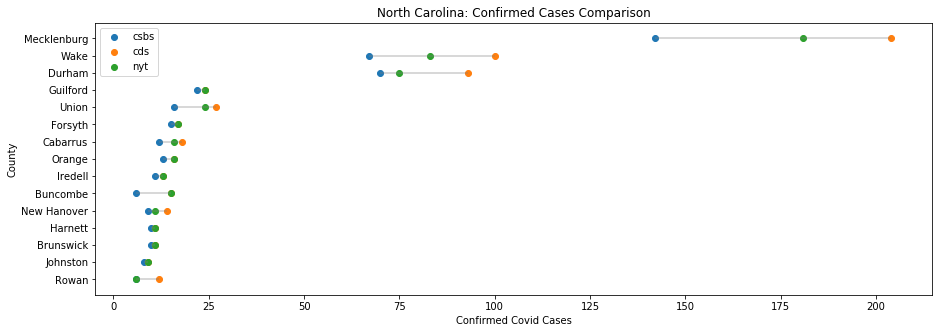

In [65]:
get_confirmed_case_comparison("North Carolina")

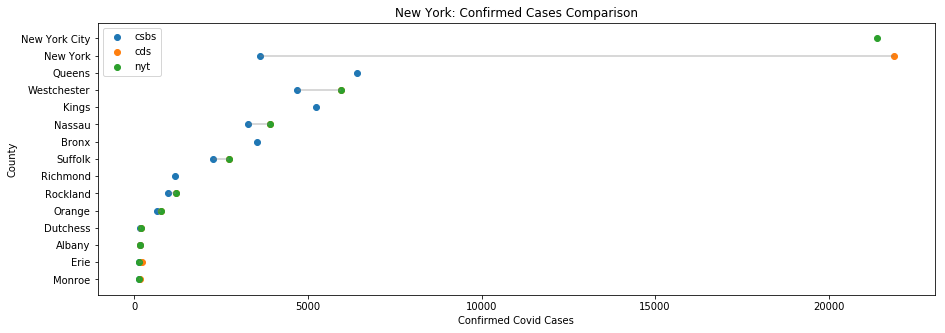

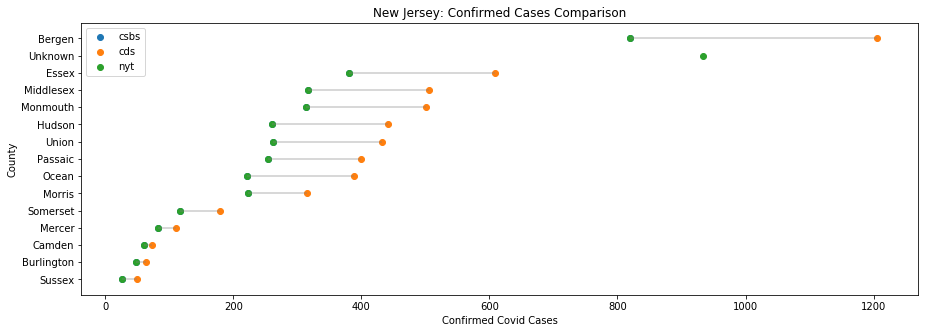

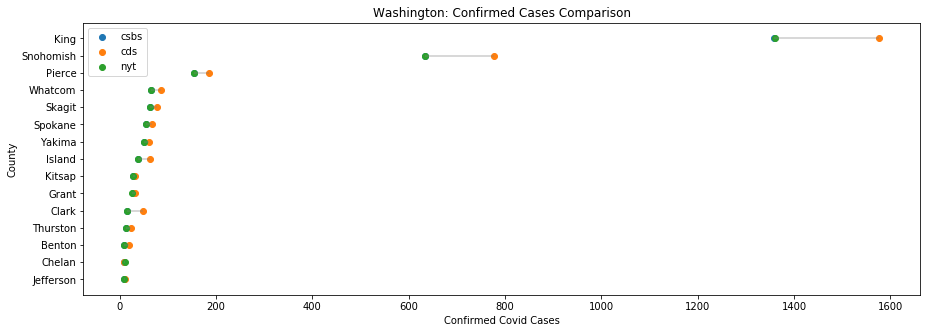

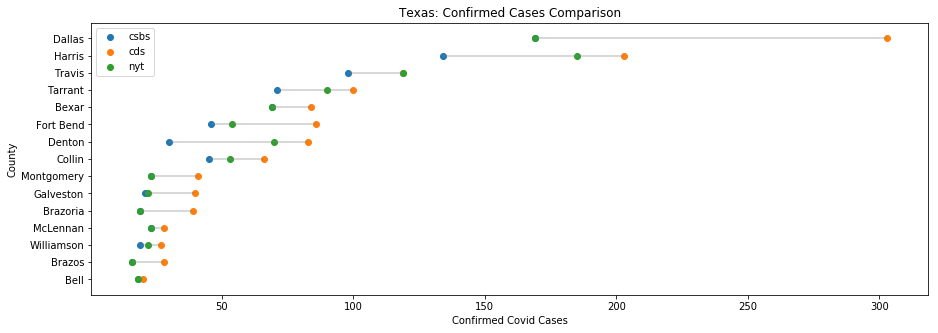

In [64]:
get_confirmed_case_comparison(["New York","New Jersey","Washington","Texas"])